In [94]:
import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
from sklearn.datasets import make_moons
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import csv
from pandas import DataFrame

from sklearn.metrics import confusion_matrix,classification_report


In [52]:
class KernelKMeans(BaseEstimator, ClusterMixin):
   
    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"


    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print ("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

Original Data


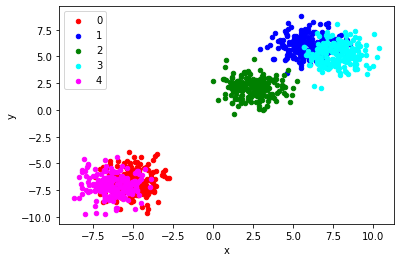

In [224]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=5, random_state=456)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Original Data")
pyplot.show()

Converged at iteration 5
[2 2 1 2 2 2 1 2 0 1]
[2 2 1 2 2 2 1 2 0 1]
Linear K-means


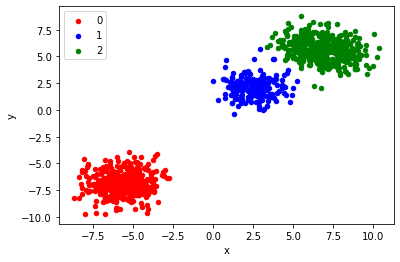

In [225]:
km = KernelKMeans(n_clusters=3, max_iter=100, random_state=0, verbose=1)
print (km.fit_predict(X)[:10])
print (km.predict(X[:10]))

y = km.predict(X)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Linear K-means")
pyplot.show()

Converged at iteration 9
[3 3 0 3 3 3 0 3 0 0]
[3 3 0 3 3 3 0 3 0 0]
Polynomial Kernel


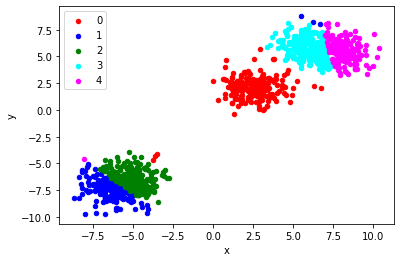

In [226]:
km = KernelKMeans(n_clusters=5, max_iter=100,kernel="polynomial",degree=2, random_state=0, verbose=1)
print (km.fit_predict(X)[:10])
print (km.predict(X[:10]))

y = km.predict(X)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Polynomial Kernel")
pyplot.show()

Converged at iteration 11
[2 2 0 2 3 2 0 2 1 0]
[2 2 0 2 3 2 0 2 1 0]
Gaussian Kernel


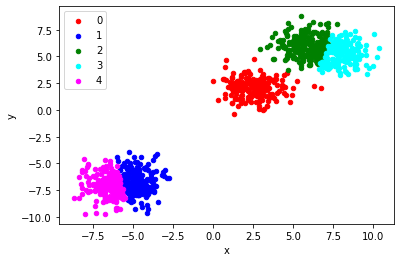

In [227]:
km = KernelKMeans(n_clusters=5, max_iter=100,kernel="rbf", random_state=0, verbose=1)
print (km.fit_predict(X)[:10])
print (km.predict(X[:10]))

y = km.predict(X)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Gaussian Kernel")
pyplot.show()

Converged at iteration 27
[2 2 0 2 3 2 0 2 4 0]
[2 2 0 2 3 2 0 2 4 0]
Laplacian Kernel


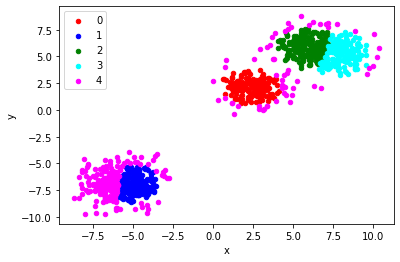

In [243]:
km = KernelKMeans(n_clusters=5, max_iter=100,kernel="laplacian",gamma=1.38, random_state=0, verbose=1)
print (km.fit_predict(X)[:10])
print (km.predict(X[:10]))

y = km.predict(X)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Laplacian Kernel")
pyplot.show()

Converged at iteration 2
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 1 0]
Sigmoid Kernel


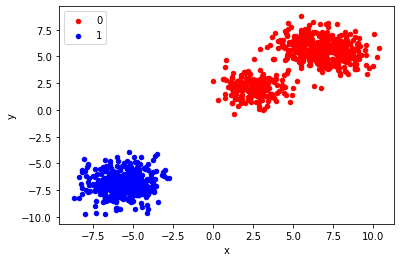

In [249]:
km = KernelKMeans(n_clusters=2, max_iter=100,kernel="sigmoid", random_state=0, verbose=1)
print (km.fit_predict(X)[:10])
print (km.predict(X[:10]))

y = km.predict(X)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Sigmoid Kernel")
pyplot.show()

Original Data


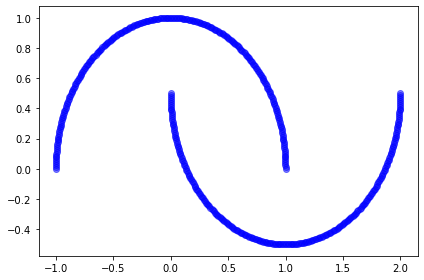

In [250]:
Xmoon, ymoon = make_moons(n_samples=500, random_state=123)
plt.scatter(Xmoon[ymoon==0, 0], Xmoon[ymoon==0, 1],color='blue', alpha=0.5)
plt.scatter(Xmoon[ymoon==1, 0], Xmoon[ymoon==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
print("Original Data")
plt.show()

Linear Kernel


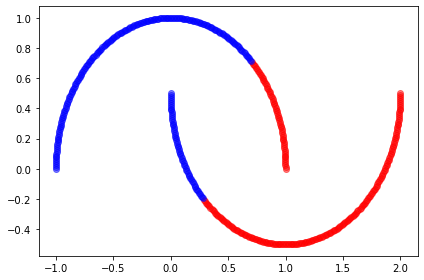

In [251]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xmoon)
y = kmeans.predict(Xmoon)
plt.scatter(Xmoon[y==0, 0], Xmoon[y==0, 1],color='red', alpha=0.5)
plt.scatter(Xmoon[y==1, 0], Xmoon[y==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
print("Linear Kernel")
plt.show()

Converged at iteration 5
[1 0 0 0 1 1 0 0 0 1]
[1 0 0 0 1 1 0 0 0 1]


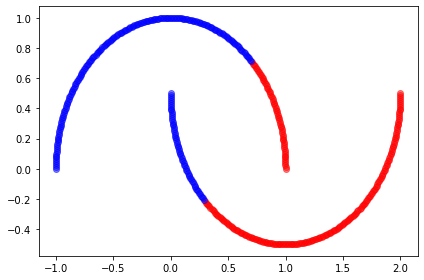

In [27]:
km1 = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1)
print (km1.fit_predict(Xmoon)[:10])
print (km1.predict(Xmoon[:10]))
y=km1.predict(Xmoon)
plt.scatter(Xmoon[y==0, 0], Xmoon[y==0, 1],color='red', alpha=0.5)
plt.scatter(Xmoon[y==1, 0], Xmoon[y==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
plt.show()

Converged at iteration 31
[1 1 1 0 1 0 0 0 0 0]
[1 1 1 0 1 0 0 0 0 0]
Gaussian Kernel


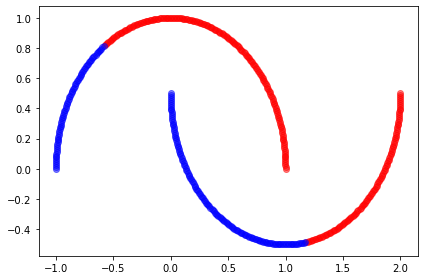

In [252]:
km1 = KernelKMeans(n_clusters=2, max_iter=100,kernel="rbf",gamma=15, random_state=0, verbose=1)
print (km1.fit_predict(Xmoon)[:10])
print (km1.predict(Xmoon[:10]))
y=km1.predict(Xmoon)
plt.scatter(Xmoon[y==0, 0], Xmoon[y==0, 1],color='red', alpha=0.5)
plt.scatter(Xmoon[y==1, 0], Xmoon[y==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
print("Gaussian Kernel")
plt.show()

Converged at iteration 5
[1 0 0 0 0 1 0 0 0 1]
[1 0 0 0 0 1 0 0 0 1]
Sigmoid Kernel


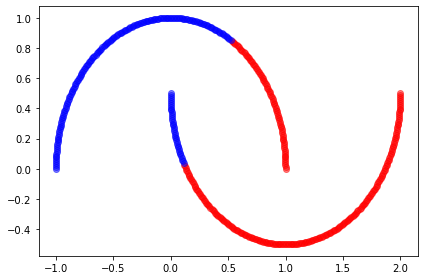

In [253]:
km1 = KernelKMeans(n_clusters=2, max_iter=100,kernel="sigmoid", random_state=0, verbose=1)
print (km1.fit_predict(Xmoon)[:10])
print (km1.predict(Xmoon[:10]))
y=km1.predict(Xmoon)
plt.scatter(Xmoon[y==0, 0], Xmoon[y==0, 1],color='red', alpha=0.5)
plt.scatter(Xmoon[y==1, 0], Xmoon[y==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
print("Sigmoid Kernel")
plt.show()

Converged at iteration 11
[1 1 1 0 1 1 0 0 0 1]
[1 1 1 0 1 1 0 0 0 1]
Polynomial Kernel


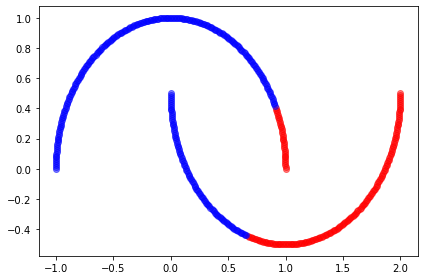

In [254]:
km1 = KernelKMeans(n_clusters=2, max_iter=100,kernel="polynomial",degree=2, random_state=0, verbose=1)
print (km1.fit_predict(Xmoon)[:10])
print (km1.predict(Xmoon[:10]))
y=km1.predict(Xmoon)
plt.scatter(Xmoon[y==0, 0], Xmoon[y==0, 1],color='red', alpha=0.5)
plt.scatter(Xmoon[y==1, 0], Xmoon[y==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
print("Polynomial Kernel")
plt.show()

Converged at iteration 10
[1 0 0 0 0 1 0 0 0 1]
[1 0 0 0 0 1 0 0 0 1]
Polynomial Kernel


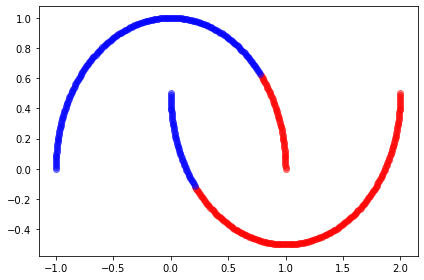

In [258]:
km1 = KernelKMeans(n_clusters=2, max_iter=100,kernel="laplacian",degree=2.5, random_state=0, verbose=1)
print (km1.fit_predict(Xmoon)[:10])
print (km1.predict(Xmoon[:10]))
y=km1.predict(Xmoon)
plt.scatter(Xmoon[y==0, 0], Xmoon[y==0, 1],color='red', alpha=0.5)
plt.scatter(Xmoon[y==1, 0], Xmoon[y==1, 1],color='blue', alpha=0.5)
plt.tight_layout()
print("Laplacian Kernel")
plt.show()

In [157]:
data_lines = pd.read_csv('tae.data', delimiter=',')


array = data_lines.values
data = array[:,0:5]
label = array[:,5]

for i in range(len(label)):
    label[i] = label[i]-1;

data_lines.head()

,EnglishSpeaker,CourseInstructor,Course,Summer,ClassSize,ClassCategory
0,1,23,3,1,19,2
1,2,15,3,1,17,2
2,1,23,3,2,49,2
3,1,5,2,2,33,2
4,2,7,11,2,55,2


Converged at iteration 3
Confusion Matrix
[[21 16 16]
 [13 14 18]
 [15 20 18]]
Linear Kernel


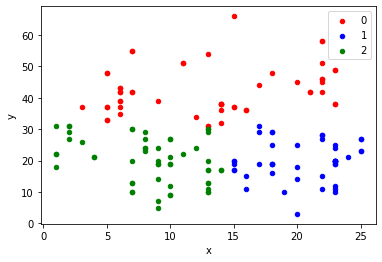

In [262]:
km_zoo = KernelKMeans(n_clusters=3, max_iter=100,kernel="linear", random_state=0, verbose=1)
km_zoo.fit_predict(data)
y = km_zoo.predict(data)

conf_matrix = confusion_matrix(y,label)
print("Confusion Matrix")
print(conf_matrix)


df = DataFrame(dict(x=data[:,1], y=data[:,4], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Linear Kernel")
pyplot.show()


Converged at iteration 10
Confusion Matrix
[[15  8 14]
 [ 6 11  8]
 [28 31 30]]
Gaussian Kernel


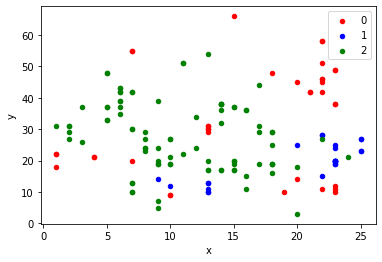

In [263]:
km_zoo = KernelKMeans(n_clusters=3, max_iter=100,kernel="rbf",gamma=0.04, random_state=0, verbose=1)
km_zoo.fit_predict(data)
y = km_zoo.predict(data)

conf_matrix = confusion_matrix(y,label)
print("Confusion Matrix")
print(conf_matrix)

df = DataFrame(dict(x=data[:,1], y=data[:,4], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Gaussian Kernel")
pyplot.show()


Converged at iteration 8
Confusion Matrix
[[ 4  0  7]
 [10 15  6]
 [35 35 39]]
Polynomial Kernel


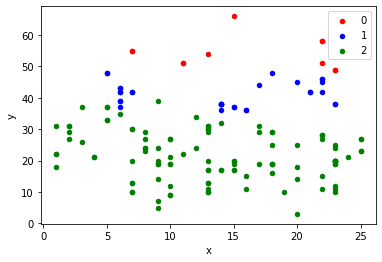

In [264]:
km_zoo = KernelKMeans(n_clusters=3, max_iter=100,kernel="polynomial",degree=4.3, random_state=0, verbose=1)
km_zoo.fit_predict(data)
y = km_zoo.predict(data)

conf_matrix = confusion_matrix(y,label)
print("Confusion Matrix")
print(conf_matrix)

df = DataFrame(dict(x=data[:,1], y=data[:,4], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
print("Polynomial Kernel")
pyplot.show()
